In [1]:
import pandas as pd
import numpy as np
from numpy import fliplr
from numpy import flipud
from numpy import array
from pandas.io.json import json_normalize
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, Activation
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import json
import math
import pymongo
from pymongo import MongoClient
import time

def connect_database():
 
    client = MongoClient('localhost', 27017)
    db = client['bitcoin']
    collection = db['final_data2']
    return db, collection

def data_extraction(filed, collection):
    '''
    extract a certain filed('close') of data from the collecttion 
    '''

    data = []
    for doc in list(collection.find())[-10300:-300]:
        data.append(doc[filed])
    data = array(data)
    #data = flipud(data)
    return data

    

def take_by_window(dataset, window):
    x, y = [], []
    for i in range(len(dataset) - window ):
        
        x.append(dataset[i:(i + window)])
        y.append(dataset[i + window,])
    x = np.array(x)
    print(x.shape)
    y = np.array(y)
    print(x.shape[0],x.shape[1])
    x = np.reshape(x, (x.shape[0] ,1 , x.shape[1]))
    print(x.shape)
    return x, y

def pred_model(test, x_train, y_train, step_size=1, num_features=3, epochs=100, batch_size=128, verbose=2, pred_num=1000):
    """
    ML model: LSTM
    Look_back: how many point
    :return:
    """

    model = Sequential()
    #model.add(LSTM(250, input_shape=(step_size, num_features), return_sequences=True))
    #model.add(Dropout(0.2))
    #model.add(LSTM(200))
    model.add(LSTM(4, input_shape=(step_size, num_features), return_sequences=True))
    model.add(Dropout(0))
    model.add(LSTM(4))
    model.add(Dropout(0))
    model.add(Dense(1))  # output file size
    model.add(Activation('tanh'))  # active function
#     model.add(Dropout(0.05))  # drop out regulation
    model.compile(loss='mse', optimizer='adam')
    model.fit(x_train, y_train, epochs=epochs, batch_size=batch_size, verbose=verbose)
    
 

    pred_test = model.predict(test)


    pred_train = model.predict(x_train)
    #pred_test = model.predict(x_test)
    #pred_dataset = array(pred_dataset)
    #print(array(x_test).shape, array(y_test).shape)
    
    #score = model.evaluate(array(x_test[0:-1]), y_test, batch_size=128)

    return pred_train , pred_test



Using TensorFlow backend.


In [2]:
np.random.seed(1234)
db, collection = connect_database()
df = data_extraction('close', collection)
t = data_extraction('_id', collection)
stm = data_extraction('mean', collection)
dataset = df.astype('float32')
t = t.astype('int32')
mms = MinMaxScaler(feature_range=(-1, 1))

'''construct a scale based on dataset'''
dataset = mms.fit_transform(dataset)

'''define the size of lookback'''
window = 10

/Users/anwang/anaconda/lib/python3.6/site-packages/sklearn/preprocessing/data.py:321: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
/Users/anwang/anaconda/lib/python3.6/site-packages/sklearn/preprocessing/data.py:356: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)


In [3]:
train_size = int(len(dataset)*0.99)
test_size = len(dataset)-train_size

In [4]:
x, y = take_by_window(dataset, window)
x_train, y_train = x[:train_size-window], y[:train_size-window]
x_test, y_test = x[train_size-window:], y[train_size-window:]

(9990, 10)
9990 10
(9990, 1, 10)


In [5]:
test_size

100

In [6]:
start_time = time.time()
pred_train, pred_test = pred_model(x_test, x_train, y_train, step_size=1, num_features=window, epochs=50, batch_size=128, verbose=2, pred_num = test_size)
run_time = time.time()-start_time
print('run time = ', time)

Instructions for updating:
keep_dims is deprecated, use keepdims instead
Instructions for updating:
keep_dims is deprecated, use keepdims instead
Epoch 1/50
1s - loss: 0.1959
Epoch 2/50
0s - loss: 0.1254
Epoch 3/50
0s - loss: 0.0505
Epoch 4/50
0s - loss: 0.0184
Epoch 5/50
0s - loss: 0.0110
Epoch 6/50
0s - loss: 0.0076
Epoch 7/50
0s - loss: 0.0056
Epoch 8/50
0s - loss: 0.0044
Epoch 9/50
0s - loss: 0.0037
Epoch 10/50
0s - loss: 0.0033
Epoch 11/50
0s - loss: 0.0030
Epoch 12/50
0s - loss: 0.0028
Epoch 13/50
0s - loss: 0.0026
Epoch 14/50
0s - loss: 0.0025
Epoch 15/50
0s - loss: 0.0024
Epoch 16/50
0s - loss: 0.0023
Epoch 17/50
0s - loss: 0.0023
Epoch 18/50
0s - loss: 0.0022
Epoch 19/50
0s - loss: 0.0021
Epoch 20/50
0s - loss: 0.0021
Epoch 21/50
0s - loss: 0.0020
Epoch 22/50
0s - loss: 0.0020
Epoch 23/50
0s - loss: 0.0019
Epoch 24/50
0s - loss: 0.0019
Epoch 25/50
0s - loss: 0.0018
Epoch 26/50
0s - loss: 0.0018
Epoch 27/50
0s - loss: 0.0017
Epoch 28/50
0s - loss: 0.0017
Epoch 29/50
0s - loss: 

In [7]:
pred_train = mms.inverse_transform(pred_train)
y_train = mms.inverse_transform(y_train)
pred_test = mms.inverse_transform(pred_test)
y_test = mms.inverse_transform(y_test)

/Users/anwang/anaconda/lib/python3.6/site-packages/sklearn/preprocessing/data.py:374: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
/Users/anwang/anaconda/lib/python3.6/site-packages/sklearn/preprocessing/data.py:374: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)


In [8]:
len(pred_test)

100

In [9]:
trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:] = np.nan
trainPredictPlot[window:len(pred_train) + window] = pred_train[:,0] 

In [10]:
testPredictPlot = np.empty_like(dataset)
testPredictPlot[:] = np.nan
testPredictPlot[len(pred_train) + window:] = pred_test.reshape(100)

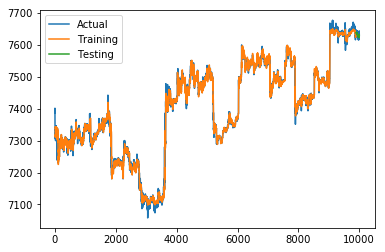

In [11]:
plt.plot(df, label='Actual')
plt.plot(pd.DataFrame(trainPredictPlot, columns=["close"]).close, label='Training')
plt.plot(pd.DataFrame(testPredictPlot, columns=["close"]).close, label='Testing')
plt.legend(loc='best')
plt.show()

In [12]:
trainScore = math.sqrt(mean_squared_error(y_train, pred_train[:, 0]))
print('Train Score: %.2f MSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(y_test, pred_test[:]))
print('Test Score: %.2f MSE' % (testScore))

Train Score: 9.71 MSE
Test Score: 4.09 MSE


In [13]:
'''count the accuracy rate of prediction based on the price up and down'''
pred = []
true = []
for i in range(0, len(pred_test)-5, 5):
    if pred_test[i+5] >= pred_test[i]:
        pred.append(1)
    else:
        pred.append(0)
    if y_test[i+5] >= y_test[i]:
        true.append(1)
    else:
        true.append(0)
            
accuracy_rate = sum(array(pred) == array(true))/len(true) 
accuracy_rate

0.6842105263157895

In [14]:
run_time

27.518338918685913

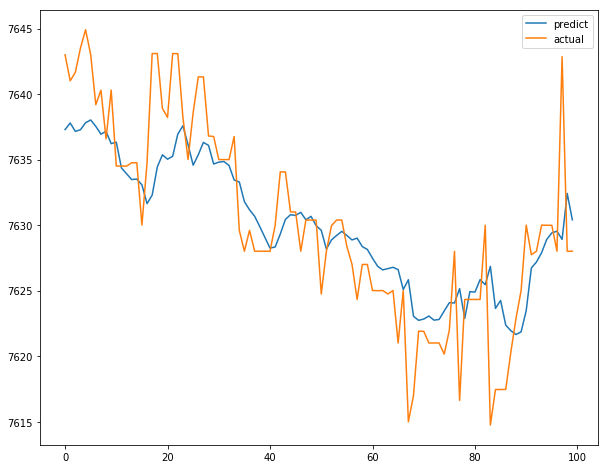

In [15]:
plt.figure(figsize=(10,8))
plt.plot(range(100),pred_test,label="predict")
plt.plot(range(100),df[-100:],label = 'actual')
plt.legend()
plt.show()

In [16]:
'''coll_test = db['test1']

for i in pred_test[:,0]:
    db.test1.insert_one({'pred_test': float(i)})'''

"coll_test = db['test1']\n\nfor i in pred_test[:,0]:\n    db.test1.insert_one({'pred_test': float(i)})"

In [17]:
df[-1500:-1400]

array([7432.05, 7432.05, 7432.05, 7441.  , 7436.5 , 7441.  , 7436.5 ,
       7436.5 , 7436.5 , 7436.5 , 7443.01, 7440.01, 7440.01, 7443.01,
       7440.  , 7443.02, 7443.01, 7443.02, 7442.98, 7442.99, 7442.08,
       7442.07, 7509.99, 7512.  , 7512.  , 7503.31, 7509.99, 7510.35,
       7510.35, 7510.35, 7510.35, 7510.34, 7510.34, 7510.35, 7510.3 ,
       7501.06, 7503.  , 7503.01, 7503.01, 7501.07, 7503.75, 7501.07,
       7503.96, 7504.92, 7509.69, 7503.33, 7503.4 , 7507.89, 7502.09,
       7502.09, 7507.83, 7507.84, 7502.26, 7504.06, 7507.84, 7500.14,
       7504.19, 7507.89, 7508.  , 7508.  , 7508.  , 7507.99, 7507.98,
       7504.9 , 7508.  , 7508.  , 7506.61, 7505.51, 7506.99, 7506.6 ,
       7505.51, 7505.51, 7505.51, 7505.5 , 7505.51, 7505.51, 7526.66,
       7506.99, 7511.  , 7515.  , 7526.66, 7526.65, 7526.66, 7526.66,
       7526.66, 7526.66, 7526.67, 7526.66, 7526.65, 7526.66, 7526.66,
       7526.65, 7526.7 , 7526.7 , 7526.67, 7526.66, 7526.66, 7526.66,
       7526.67, 7526